# Reading Petrel points

In [1]:
import re
import numpy as np
from io import StringIO

In [2]:
import geopandas as gp
from shapely.geometry import Point, LineString

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
points_file = "Petrel_points_extract.txt"

Let's look at the start of the file:

In [5]:
with open(points_file) as f:
    c = f.read()
print(c[:256])

# Petrel Points with attributes
# Unit in X and Y direction: m
# Unit in depth: m
VERSION 1
BEGIN HEADER
X
Y
Z
END HEADER
374667.10 4541269.76 -5199.68 
374662.03 4541281.19 -5199.59 
374656.96 4541292.62 -5199.50 
374651.89 4541304.04 -5199.44 
374646.83 


We can make a function to parse the header into some variables, and read the bulk of the file – the data — into a NumPy array.

In [6]:
def gdf_from_points(points_file):
    """
    Read a Petrel points file and create a GeoPandas DataFrame.
    """
    with open(points_file) as f:
        comments, fields = [], []
        in_header = False

        while True:
            line = f.readline().strip()
            if line.startswith('#'):
                comments.append(line.strip('# '))
            elif line.startswith('VERSION'):
                version = line.split()[-1]
            elif line.startswith('BEGIN'):
                in_header = True
            elif line.startswith('END'):
                in_header = False
                break
            elif in_header:
                fields.append(line.strip())
            else:
                break

        d = f.read()
        s = StringIO(d)
        data = np.loadtxt(s)

        geoseries = gp.GeoSeries([Point(r[0], r[1]).buffer(5) for r in data])
        d = {'geometry': geoseries, 'twt': -data[:,2]}

        return gp.GeoDataFrame(d)

Read the subset of data:

In [7]:
seafloor = gdf_from_points(points_file)

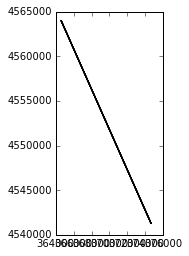

In [8]:
seafloor.plot()
plt.show()

## Petrel horizons

In [153]:
horizon_file = "Sydney_horizons"

In [154]:
with open(horizon_file) as f:
    c = f.read()
    
print(c[:512])

PROFILE Seismic horizon 2    TYPE 1  5 By Petrel 2014.2 (64-bit)                2d_ci7m_gf.ifdf  m  ms
SNAPPING PARAMETERS 2     2 2
 -1.94522407E+05  5.15279459E+06  1 14   722.27      0.00      0.00    0               2 out_MUR72-SYD-02_STK_klmn.SGY             
 -1.94524427E+05  5.15278011E+06  1 14   720.99      0.00      0.00    1               2 out_MUR72-SYD-02_STK_klmn.SGY             
 -1.94526448E+05  5.15276563E+06  1 14   720.67      0.00      0.00    2               2 out_MUR72-SYD-02_STK_klmn.


Not totally sure what all these fields are. There seems to be two rows of header info for each horizon. This is followed by space-delimited data fields with columns as follows:

1. X-coordinate, float
1. Y-coordinate, float
1. Segment number, int
1. Symbol code, int
1. Two-way time (ms), float
1. Shot-point number, float
1. CDP number, float
1. Trace number, int
1. Line type (2=2D, I=inline, X=crossline), int
1. 2D line name or 3D survey name, str

I have asked about this [on Stack Exchange](http://earthscience.stackexchange.com/questions/4897/what-are-the-fields-in-petrels-iesx-seismic-horizon-file) and on LinkedIn. 

In [155]:
import re
s = "PROFILE Fault to seafloor    TYPE 1  5 By Petrel 2014.2 (64-bit)                2d_ci7m_gf.ifdf  m  ms"
re.search(r'PROFILE (.+?) +TYPE', s).group(1)

'Fault to seafloor'

I think we can use the first integer as a sort of flag to determine the start of a new 'segment'. 

I want to make a shapefile with line segments, I think. Not totally sure about that...

In [156]:
import operator, re

def gdf_from_iesx(filename, threed=False):
    """
    Read a Petrel IESX file and create a GeoPandas DataFrame.
    """
    with open(filename) as f:

        points, linestrings, names = [], [], []
        mins, maxs = [], []
        min_sfls, max_sfls = [], []
        minx, miny = [], []
        last_cdp = 0
        skip = False
        
        while True:
            line = f.readline().strip()        
            if not line:
                # End of file
                break
            elif line.startswith('EOD'):
                # End of horizon
                last_cdp = 0 # Force capture
            elif line.startswith('SNAPPING'):
                continue
            elif line.startswith('PROFILE'):
                name = re.search(r'PROFILE (.+?) +TYPE', line).group(1)
                
                # Some 'label' horizons slipped though, skip 'em.
                if name.startswith('---'):
                    skip = True
                else:
                    skip = False
                    print()
                    print(name, end="")
            else:
                if skip == True:
                    continue
                
                line = line.split()
                x, y = float(line[0]), float(line[1])
                twtt = float(line[4])

                if threed:
                    this_cdp = int(line[5]) + int(line[9])
                else:
                    this_cdp = int(line[7])

                if abs(this_cdp - last_cdp) < 2:
                    # Then it's a regular line, so keep adding
                    points.append(Point(x, y, twtt))
                    last_cdp = this_cdp
                else:
                    if len(points) < 2:
                        last_cdp = this_cdp
                        continue
                        
                    print('.', end="")

                    # Capture what we have
                    linestrings.append(LineString(points))
                    names.append(name)
                    zs = [p.z for p in points]
                    
                    # We want the value and index of the min and max in the list of z values
                    min_idx, min_val = min(enumerate(zs), key=operator.itemgetter(1))
                    max_idx, max_val = max(enumerate(zs), key=operator.itemgetter(1))
                    
                    # Record the values and shallowest point in our master lists
                    mins.append(min_val)
                    maxs.append(max_val)
                    
                    p = points[min_idx]
                    minx.append(p.x)
                    miny.append(p.y)
                    
                    # Make GeoDataFrames from the points yielding the min and max
                    min_gdf = gp.GeoDataFrame({'geometry':gp.GeoSeries(p)})
                    max_gdf = gp.GeoDataFrame({'geometry':gp.GeoSeries(points[max_idx])})
                    
                    # Reset segment and carry on
                    last_cdp = this_cdp
                    points = [Point(x, y, twtt)]
                    
    return gp.GeoDataFrame({'geometry': linestrings,
                            'name': names,
                            'min': mins,
                            'max': maxs,
                            'minx': minx,
                            'miny': miny
                           })

In [159]:
hrz = gdf_from_iesx(horizon_file)


Seismic horizon 2...
Seismic horizon 2........
Sydney River Fm.
South Bar Marker 05..................
South Bar Marker 10............
South Bar Marker 20...........
South Bar Marker 20.
Seismic horizon 1...
Westphalian Unc........
Westphalian Unc......................................................
Penn 100.
Miss-Penn Unc...
Miss-Penn Unc.
Base Windsor Unc..............
Base Windsor Unc.......
Basement.................................
Basement.........
Basement..........................................

In [160]:
from fiona.crs import from_epsg
hrz.crs = from_epsg(26722)

Try a quick plot...

Test on a small bit:

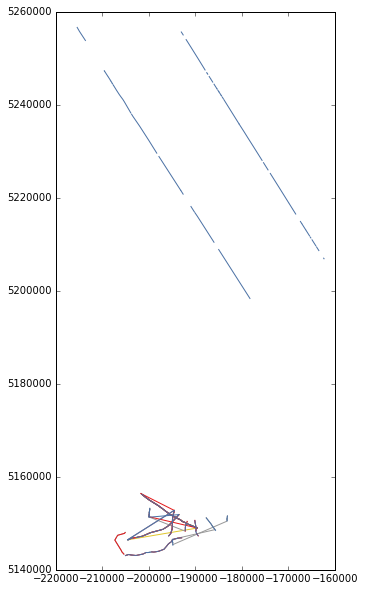

In [161]:
fig = plt.figure(figsize=(18,10))
ax = hrz.plot(column='name')
plt.show()

In [162]:
hrz['geometry'].to_crs(crs=None, epsg=26920)

0      LINESTRING Z (731683.687887352 5117889.9972289...
1      LINESTRING Z (731681.5877891231 5117498.140930...
2      LINESTRING Z (731633.9364844268 5117300.292968...
3      LINESTRING Z (731593.463047051 5116867.8109724...
4      LINESTRING Z (737068.468222586 5114909.5165788...
5      LINESTRING Z (734331.3604499635 5115661.478184...
6      LINESTRING Z (733284.4374612803 5116078.371199...
7      LINESTRING Z (732906.0822050162 5116172.024291...
8      LINESTRING Z (732831.0148198947 5117138.367329...
9      LINESTRING Z (730883.4187244967 5114382.163269...
10     LINESTRING Z (726777.4839666354 5112016.051302...
11     LINESTRING Z (724137.8045736514 5110792.793262...
12     LINESTRING Z (732442.1646933955 5116602.195704...
13     LINESTRING Z (731264.3574950895 5114852.524607...
14     LINESTRING Z (729664.5862785939 5113423.481207...
15     LINESTRING Z (729585.2624221456 5113367.270033...
16     LINESTRING Z (729384.2588224567 5113261.121262...
17     LINESTRING Z (729013.813

## Petrel Horizons to simple 3 column ascii files

In [213]:
p = Point(100000, 200000, 100.0)
points = gp.GeoDataFrame({'geometry':gp.GeoSeries(p)})
points.crs = from_epsg(26722)
converted = points.to_crs(epsg=26920)
pc = converted['geometry']
xs = [p.x for p in pc]
xs = [p.y for p in pc]


[1438296.9001811147]

In [290]:
def dict_from_iesx(filename, threed=False, conv_espg=26920):
    """
    Read a Petrel IESX file and create a GeoPandas DataFrame.
    """
    with open(filename) as f:
        horizons = {}
        data, name = [], []
        last_cdp = 0
        skip = False
        
        while True:
            line = f.readline().strip()        
            if not line:
                # End of file
                break
            elif line.startswith('EOD'):
                # End of horizon
                last_cdp = 0 # Force capture
            elif line.startswith('SNAPPING'):
                continue
            elif line.startswith('PROFILE'):
                name = re.search(r'PROFILE (.+?) +TYPE', line).group(1)
                
                # Some 'label' horizons slipped though, skip 'em.
                if name.startswith('---'):
                    skip = True
                else:
                    skip = False
                    print()
                    print(name, end="")
            else:
                if skip == True:
                    continue
                    
                line = line.split()
                x, y = float(line[0]), float(line[1])
                twtt = float(line[4])
                
                point = Point(x, y, twtt)
                points = gp.GeoDataFrame({'geometry':gp.GeoSeries(point)})
                points.crs = from_epsg(26722)
                converted = points.to_crs(epsg=26920)
                pc = converted['geometry']
                xs = [p.x for p in pc][0]
                ys = [p.y for p in pc][0]
                
                if name not in horizons:    
                    horizons[name] = []
                
                horizons[name].append([xs, ys, twtt])

                if threed:
                    this_cdp = int(line[5]) + int(line[9])
                else:
                    this_cdp = int(line[7])
            
                
        # Turn the list of lists into an array
        #for horizon in horizons:
        #    horizon[horizon] = np.array(horizon[horizon])
              
    return horizons

In [291]:
x, y = -1.89550179E+05,  5.14898374E+06
p = Point(x, y, 200)
points = gp.GeoDataFrame({'geometry':gp.GeoSeries(p)})
points.crs = from_epsg(26922)
converted = points.to_crs(epsg=26920)
converted
#pc = converted['geometry']
#xs = [p.x for p in pc][0]
#ys = [p.y for p in pc][0]
#xs, ys

,geometry
0,POINT Z (737097.0099933511 5114662.999070914 200)


In [292]:
hrz = dict_from_iesx(horizon_file)


Seismic horizon 2
Seismic horizon 2
Sydney River Fm.
South Bar Marker 05
South Bar Marker 10
South Bar Marker 20
South Bar Marker 20
Seismic horizon 1
Westphalian Unc.
Westphalian Unc.
Penn 100
Miss-Penn Unc.
Miss-Penn Unc.
Base Windsor Unc.
Base Windsor Unc.
Basement
Basement
Basement

In [295]:
def reformat_horizon_dict(horizons):
    """
    Takes a dictionary of horizons and puts the values into an np array
    """
    for key in horizons:
        horizons[key] = np.array(horizons[key])
    return horizons

In [296]:
new_hrz = reformat_horizon_dict(hrz)

In [297]:
new_hrz.keys()

dict_keys(['South Bar Marker 05', 'Seismic horizon 2', 'Base Windsor Unc.', 'South Bar Marker 10', 'Seismic horizon 1', 'Sydney River Fm.', 'Basement', 'South Bar Marker 20', 'Westphalian Unc.', 'Penn 100', 'Miss-Penn Unc.'])

In [298]:
new_hrz['Basement']

array([[  7.31635011e+05,   5.11766399e+06,   7.21300000e+02],
       [  7.31635199e+05,   5.11764945e+06,   7.20890000e+02],
       [  7.31635387e+05,   5.11763491e+06,   7.20470000e+02],
       ..., 
       [  7.55774009e+05,   5.17501199e+06,   1.01153000e+03],
       [  7.55790195e+05,   5.17499301e+06,   1.01279000e+03],
       [  7.55806383e+05,   5.17497402e+06,   1.01282000e+03]])

In [299]:
pwd

'/Users/Evan/gio/hack'

In [300]:
def write_geotransect_horizons(horizons_dict, fmt='%10.2f'):
    for key in horizons_dict:
        np.savetxt(key +'.txt', horizons_dict[key], header=key, fmt=fmt, delimiter=' ', newline='\n')
    return

In [301]:
write_geotransect_horizons(new_hrz)

Add a CRS...

Write a file if you like.

Checking Byte postition

In [143]:
position = 0  # or wherever you left off last time
try:
    with open('Basement.txt') as file:
        file.seek(position)  # zero in base case
        for line in file:
            position = file.tell() # current seek position in file
            # process the line
except:
    print ('exception occurred at position {}'.format(position))
    raise

exception occurred at position 0


OSError: telling position disabled by next() call

In [27]:
# hrz.to_file('horizons_2d_UTM20N_NAD27.shp')

## Petrel well headers

A format for importing wells into Petrel (or exporting from Petrel?). (Leaving this for later.)

    # Petrel well head
    VERSION 1							
    BEGIN HEADER							
    Well_ID							
    Well_sequence_number							
    Well_name							
    Surface X [m] NAD 83							
    Surface Y [m] NAD 83							
    KB elevation above sea level							
    TD [m]							
    Operator							
    END HEADER							
     ' P-139 ' 	 ' 139 ' 	 ' ECE-13-P2_ST ' 	529557	5045390	44.68	1,259.00	 ' East Coast Energy ' 
     ' P-138 ' 	 ' 138 ' 	 ' ECE-13-P1 ' 	529996	5045966	39.89	700	 ' East Coast Energy ' 
     ' P-137 ' 	 ' 137 ' 	 ' Forent South Branch No.1 K-70-D/11-E-03 ' 	496239	5003586	55.9	784	 ' Forent Energy Ltd ' 
     ' P-136 ' 	 ' 136 ' 	 ' Forent Alton No. 1 E-49-C 11-E-03  ' 	479105	5003441	40.23	1001	 ' Forent Energy Ltd. ' 
     ' P-135 ' 	 ' 135 ' 	 ' E-38-A/11-E-5 ' 	420980	5056480	123	946	 ' Eastrock Resources ' 
     ' P-134 ' 	 ' 134 ' 	 ' ECE-11-01 ' 	529976	5045865	43	678	 ' East Coast Energy ' 
     ' P-133 ' 	 ' 133 ' 	 ' E-38-A/11-E-5 ' 	443001	5015963	51	1726	 ' Elmworth Energy Corporation ' 